In [11]:
import numpy as np
import argparse
from copy import deepcopy
import gym
import torch
import time

In [12]:
import sys
sys.path.append(os.path.join(os.getcwd(), 'Simulator'))
sys.path.append(os.path.join(os.getcwd(), 'Wolptinger'))

In [13]:
from Wolptinger.ddpg import DDPG
from Wolptinger.utils import *
from Wolptinger.evaluator import Evaluator

from Simulator.WordCounting import WordCountingEnv

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
step_collection = []
def train(num_iterations, agent, env, evaluate, validate_steps, output, max_episode_length=None, debug=False):
    agent.is_training = True
    step = episode = episode_steps = 0
    episode_reward = 0.
    observation = None

    while step < num_iterations:
        # reset if it is the start of episode
        if observation is None:
            # the original method use deepcopy here
            observation = env.reset()
            agent.reset(observation)
        
        # agent choose action
        if step < args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(observation)
        
        
        next_state, reward, done, info = env.step(action)
        if max_episode_length and episode_steps >= max_episode_length - 1:
            done = True
        
        # agent observe and update policy
        agent.observe(reward, next_state, done)
        if step > args.warmup:
            agent.update_policy()
        
        step_collection.append(reward)
        
        # evaluate the model
        # I personally don't think this will work, also, this will let the model memory a wrong
        # action
        if evaluate is not None and validate_steps > 0 and step % validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward = evaluate(env, policy, debug=False, visualize=False, save=False)
            if debug: 
                prYellow('[Evaluate] Step_{:07d}: mean_reward:{}'.format(step, validate_reward))
            agent.s_t = observation
            agent.a_t = action

        # save intermidate training model
        if step % int(num_iterations/3) == 0:
            agent.save_model(output)
        
        # update models
        step += 1
        episode_steps += 1
        episode_reward += reward
        observation = next_state
        
        # end of episode
        if done:
            if debug:
                prLightPurple(f'#{episode}: episode_reward: {episode_reward} steps:{step}')
            
            # agent.memory.append(
            #     observation,
            #     agent.select_action(observation)
            #     0.,
            #     False
            # )

            # reset
            observation = None
            episode_steps = 0
            episode_reward = 0.
            episode += 1

In [22]:
def test(num_episodes, agent, env, evaluate, model_path, visualize=True, debug=False):

    agent.load_weights(model_path)
    agent.is_training = False
    agent.eval()
    policy = lambda x: agent.select_action(x, decay_epsilon=False)

    for i in range(num_episodes):
        validate_reward = evaluate(env, policy, debug=debug, visualize=visualize, save=False)
        if debug: 
            prYellow('[Evaluate] #{}: mean_reward:{}'.format(i, validate_reward))

In [23]:
class Arguments(object):
    def __init__(self):
        self.mode = 'train'
        # self.env = "InvertedPendulum-v2"
        self.env = 'WordCountingEnv'
        self.h1 = 128
        self.h2 = 128
        self.rate = 1e-3
        self.prate = 1e-3
        self.warmup = 100
        self.discount = 0.99
        self.bsize = 64
        self.rmsize = 10000
        self.window_length = 1
        self.tau = 0.001
        self.ou_theta = 0.15
        self.ou_sigma = 0.2
        self.ou_mu = 0.0
        self.validate_episodes = 20
        self.max_episode_length = 50
        self.validate_steps = 2000
        self.output = 'output'
        self.debug = True
        self.init_w = 0.003
        self.train_iter = 15000
        # self.epsilon = 50000
        self.epsilon = 10000
        self.seed = -1
        self.resume = 'default'
        self.k_ratio = 1e-6
        # we pass in the pre_generated action space
        self.action_space = None

args = Arguments()

In [24]:
args.output = get_output_folder(args.output, args.env)
if args.resume == 'default':
    args.resume = 'WordCountingDDPG/{}-run0'.format(args.env)

# env = NormalizedEnv(gym.make(args.env))
# env = gym.make(args.env)
env = WordCountingEnv()
args.low = env.action_space.low
args.high = env.action_space.high

if args.seed > 0:
    np.random.seed(args.seed)
    env.seed(args.seed)

nb_states = env.observation_space.shape[0]
nb_actions = env.action_space.shape[0]

agent = DDPG(nb_states, nb_actions, args)
evaluate = Evaluator(args.validate_episodes, 
    args.validate_steps, args.output, max_episode_length=args.max_episode_length)

start_time = time.time()

if args.mode == 'train':
    train(args.train_iter, agent, env, None, 
        args.validate_steps, args.output, max_episode_length=args.max_episode_length, debug=args.debug)
    end_time = time.time()

elif args.mode == 'test':
    test(args.validate_episodes, agent, env, evaluate, args.resume,
        visualize=True, debug=args.debug)

else:
    raise RuntimeError('undefined mode {}'.format(args.mode))

C:\Users\87312\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Building Topology
spout 2
WordCount 9
Database 9
torch.Size([128, 17])
torch.Size([128, 17])
 #0: episode_reward: -32974.56357375059 steps:50
 #1: episode_reward: -41896.05356575208 steps:100


c:\Users\87312\Documents\GitHub\Storm-auto-scheduler\Wolptinger\utils.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(
c:\Users\87312\Documents\GitHub\Storm-auto-scheduler\Wolptinger\ddpg.py:140: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_q_values.volatile=False


 #2: episode_reward: -52609.19434552513 steps:150
 #3: episode_reward: -68395.47994675767 steps:200
 #4: episode_reward: -69373.35706054304 steps:250
 #5: episode_reward: -77034.32283299316 steps:300
 #6: episode_reward: -66012.19252378878 steps:350
 #7: episode_reward: -66425.99537653786 steps:400
 #8: episode_reward: -64091.337564226174 steps:450
 #9: episode_reward: -88630.69376883944 steps:500
 #10: episode_reward: -67304.71059105097 steps:550
 #11: episode_reward: -68131.13581847039 steps:600
 #12: episode_reward: -68900.10848252174 steps:650
 #13: episode_reward: -72442.21078653612 steps:700
 #14: episode_reward: -82985.87903975631 steps:750
 #15: episode_reward: -68557.10735932685 steps:800
 #16: episode_reward: -69251.34239520617 steps:850
 #17: episode_reward: -72381.44189058879 steps:900
 #18: episode_reward: -87197.39749371124 steps:950
 #19: episode_reward: -71359.64141579099 steps:1000
 #20: episode_reward: -54374.05388039738 steps:1050
 #21: episode_reward: -72868.4627442

In [31]:
env = WordCountingEnv()
state = env.reset()

for i in range(10):
    action = agent.random_action()
    state, reward, _, _ = env.step(action)
    print(reward)

Building Topology
spout 2
WordCount 9
Database 9
-767.244914499991
-456.9137302499974
-2294.0026425000297
-2855.0692114999943
-277.7134844998836
-495.9169837500946
-29.916062249986105
-1620.444776749903
-332.764782500067
-243.30667399991722


In [33]:
import matplotlib.pyplot as plt

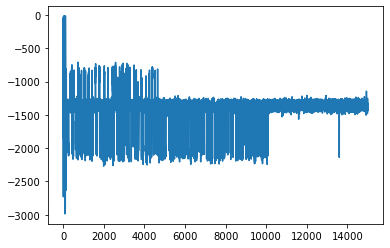

In [34]:
plt.plot(range(15000), step_collection)
plt.show()